In [4]:
import os,sys
import numpy as np
from random import seed, shuffle
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)
import os,sys

In [5]:
# if use colab

#from google.colab import drive
#drive.mount('/content/gdrive')
#!ls /content/gdrive/My\ Drive/Colab\ Notebooks/fair-classification-master/fair-classification-master/fair_classification
#sys.path.append('/content/gdrive/My Drive/Colab Notebooks/fair-classification-master/fair-classification-master/fair_classification')


In [6]:
thirdparty='./fair-classification-master/fair-classification-master/fair_classification'

In [7]:
sys.path.insert(0,thirdparty)
import utils as ut
import loss_funcs as lf # loss funcs that can be optimized subject to various constraints

In [8]:
def load_adult_data(filepath, load_data_size=None):

    """
        if load_data_size is set to None (or if no argument is provided), then we load and return the whole data
        if it is a number, say 10000, then we will return randomly selected 10K examples
    """

    attrs = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 
             'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
             'hours_per_week', 'native_country'] # all attributes
    int_attrs = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'] # attributes with integer values -- the rest are categorical
    sensitive_attrs = ['sex'] # the fairness constraints will be used for this feature
    attrs_to_ignore = ['sex', 'race' ,'fnlwgt'] # sex and race are sensitive feature so we will not use them in classification, we will not consider fnlwght for classification since its computed externally and it highly predictive for the class (for details, see documentation of the adult data)
    attrs_for_classification = set(attrs) - set(attrs_to_ignore)

    # adult data comes in two different files, one for training and one for testing, however, we will combine data from both the files
    data_files = [filepath+"/adult.data", filepath+"/adult.test"]

    X = []
    y = []
    x_control = {}

    attrs_to_vals = {} # will store the values for each attribute for all users
    for k in attrs:
        if k in sensitive_attrs:
            x_control[k] = []
        elif k in attrs_to_ignore:
            pass
        else:
            attrs_to_vals[k] = []

    for f in data_files:
        for line in open(f):
            line = line.strip()
            if line == "": continue # skip empty lines
            line = line.split(", ")
            if len(line) != 15 or "?" in line: # if a line has missing attributes, ignore it
                continue

            class_label = line[-1]
            if class_label in ["<=50K.", "<=50K"]:
                class_label = -1
            elif class_label in [">50K.", ">50K"]:
                class_label = +1
            else:
                raise Exception("Invalid class label value")

            y.append(class_label)


            for i in range(0,len(line)-1):
                attr_name = attrs[i]
                attr_val = line[i]
                # reducing dimensionality of some very sparse features
                if attr_name == "native_country":
                    if attr_val!="United-States":
                        attr_val = "Non-United-Stated"
                elif attr_name == "education":
                    if attr_val in ["Preschool", "1st-4th", "5th-6th", "7th-8th"]:
                        attr_val = "prim-middle-school"
                    elif attr_val in ["9th", "10th", "11th", "12th"]:
                        attr_val = "high-school"

                if attr_name in sensitive_attrs:
                    x_control[attr_name].append(attr_val)
                elif attr_name in attrs_to_ignore:
                    pass
                else:
                    attrs_to_vals[attr_name].append(attr_val)

    def convert_attrs_to_ints(d): # discretize the string attributes
        for attr_name, attr_vals in d.items():
            if attr_name in int_attrs: continue
            uniq_vals = sorted(list(set(attr_vals))) # get unique values

            # compute integer codes for the unique values
            val_dict = {}
            for i in range(0,len(uniq_vals)):
                val_dict[uniq_vals[i]] = i

            # replace the values with their integer encoding
            for i in range(0,len(attr_vals)):
                attr_vals[i] = val_dict[attr_vals[i]]
            d[attr_name] = attr_vals

    
    # convert the discrete values to their integer representations
    convert_attrs_to_ints(x_control)
    convert_attrs_to_ints(attrs_to_vals)


    # if the integer vals are not binary, we need to get one-hot encoding for them
    for attr_name in attrs_for_classification:
        attr_vals = attrs_to_vals[attr_name]
        if attr_name in int_attrs or attr_name == "native_country": # the way we encoded native country, its binary now so no need to apply one hot encoding on it
            X.append(attr_vals)

        else:            
            attr_vals, index_dict = ut.get_one_hot_encoding(attr_vals)
            for inner_col in attr_vals.T:                
                X.append(inner_col) 


    # convert to numpy arrays for easy handline
    X = np.array(X, dtype=float).T
    y = np.array(y, dtype = float)
    for k, v in x_control.items(): x_control[k] = np.array(v, dtype=float)
        
    # shuffle the data
    perm = [i for i in range(len(y))]#range(0,len(y)) # shuffle the data before creating each fold
    shuffle(perm)
    X = X[perm]
    y = y[perm]
    for k in x_control.keys():
        x_control[k] = x_control[k][perm]

    # see if we need to subsample the data
    if load_data_size is not None:
        #print "Loading only %d examples from the data" % load_data_size
        X = X[:load_data_size]
        y = y[:load_data_size]
        for k in x_control.keys():
            x_control[k] = x_control[k][:load_data_size]

    return X, y, x_control

In [9]:
def test_adult_data(filepath='./data'):
    """ Load the adult data """
    #X, y, x_control = load_adult_data('/content/gdrive/My Drive/Colab Notebooks',load_data_size=10000)#load_adult_data(load_data_size=10000) # set the argument to none, or no arguments if you want to test with the whole data -- we are subsampling for performance speedup
    X, y, x_control = load_adult_data(filepath,load_data_size=10000)#load_adult_data(load_data_size=10000) # set the argument to none, or no arguments if you want to test with the whole data -- we are subsampling for performance speedup
    ut.compute_p_rule(x_control["sex"], y) # compute the p-rule in the original data

    """ Split the data into train and test """
    X = ut.add_intercept(X) # add intercept to X before applying the linear classifier
    train_fold_size = 0.7
    x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

    apply_fairness_constraints = None
    apply_accuracy_constraint = None
    sep_constraint = None

    loss_function = lf._logistic_loss
    sensitive_attrs = ["sex"]
    sensitive_attrs_to_cov_thresh = {}
    gamma = None

    def train_test_classifier():
        w = ut.train_model(x_train, y_train, x_control_train, loss_function, 
                           apply_fairness_constraints, apply_accuracy_constraint, 
                           sep_constraint, sensitive_attrs, 
                           sensitive_attrs_to_cov_thresh, gamma)
        train_score, test_score, correct_answers_train, correct_answers_test = ut.check_accuracy(w, x_train, y_train, x_test, y_test, None, None)
        distances_boundary_test = (np.dot(x_test, w)).tolist()
        all_class_labels_assigned_test = np.sign(distances_boundary_test)
        correlation_dict_test = ut.get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
        cov_dict_test = ut.print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)
        p_rule = ut.print_classifier_fairness_stats([test_score], [correlation_dict_test], [cov_dict_test], sensitive_attrs[0])	
        return w, p_rule, test_score


    """ Classify the data while optimizing for accuracy """
    print
    print("== Unconstrained (original) classifier ==")
    # all constraint flags are set to 0 since we want to train an unconstrained (original) classifier
    apply_fairness_constraints = 0
    apply_accuracy_constraint = 0
    sep_constraint = 0
    w_uncons, p_uncons, acc_uncons = train_test_classifier()

    """ Now classify such that we optimize for accuracy while achieving perfect fairness """
    apply_fairness_constraints = 1 # set this flag to one since we want to optimize accuracy subject to fairness constraints
    apply_accuracy_constraint = 0
    sep_constraint = 0
    sensitive_attrs_to_cov_thresh = {"sex":0}
    print
    print("== Classifier with fairness constraint ==")
    w_f_cons, p_f_cons, acc_f_cons  = train_test_classifier()

    """ Classify such that we optimize for fairness subject to a certain loss in accuracy """
    apply_fairness_constraints = 0 # flag for fairness constraint is set back to0 since we want to apply the accuracy constraint now
    apply_accuracy_constraint = 1 # now, we want to optimize fairness subject to accuracy constraints
    sep_constraint = 0
    gamma = 0.5 # gamma controls how much loss in accuracy we are willing to incur to achieve fairness -- increase gamme to allow more loss in accuracy
    print("== Classifier with accuracy constraint ==")
    w_a_cons, p_a_cons, acc_a_cons = train_test_classifier()	

    """ 
    Classify such that we optimize for fairness subject to a certain loss in accuracy 
    In addition, make sure that no points classified as positive by the unconstrained (original) classifier are misclassified.

    """
    apply_fairness_constraints = 0 # flag for fairness constraint is set back to0 since we want to apply the accuracy constraint now
    apply_accuracy_constraint = 1 # now, we want to optimize accuracy subject to fairness constraints
    sep_constraint = 1 # set the separate constraint flag to one, since in addition to accuracy constrains, we also want no misclassifications for certain points (details in demo README.md)
    gamma = 1000.0
    print("== Classifier with accuracy constraint (no +ve misclassification) ==")
    w_a_cons_fine, p_a_cons_fine, acc_a_cons_fine  = train_test_classifier()

    return

In [ ]:
test_adult_data()

In [11]:
def test_adult_data_max_acc_under_fairness_constraints(crange,filepath='./data'):
    """ Load the adult data """
    X, y, x_control = load_adult_data(filepath,load_data_size=30000) # set the argument to none, or no arguments if you want to test with the whole data -- we are subsampling for performance speedup
    ut.compute_p_rule(x_control["sex"], y) # compute the p-rule in the original data

    """ Split the data into train and test """
    X = ut.add_intercept(X) # add intercept to X before applying the linear classifier
    train_fold_size = 0.7
    x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

    apply_fairness_constraints = None
    apply_accuracy_constraint = None
    sep_constraint = None

    loss_function = lf._logistic_loss
    sensitive_attrs = ["sex"]
    sensitive_attrs_to_cov_thresh = {}
    gamma = None

    def train_test_classifier():
        w = ut.train_model(x_train, y_train, x_control_train, loss_function, 
                           apply_fairness_constraints, apply_accuracy_constraint, 
                           sep_constraint, sensitive_attrs, 
                           sensitive_attrs_to_cov_thresh, gamma)
        train_score, test_score, correct_answers_train, correct_answers_test = ut.check_accuracy(w, x_train, y_train, x_test, y_test, None, None)
        distances_boundary_test = (np.dot(x_test, w)).tolist()
        all_class_labels_assigned_test = np.sign(distances_boundary_test)
        correlation_dict_test = ut.get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
        cov_dict_test = ut.print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)
        p_rule = ut.print_classifier_fairness_stats([test_score], [correlation_dict_test], [cov_dict_test], sensitive_attrs[0])	
        return w, p_rule, test_score


    """ Classify the data while optimizing for accuracy """
    print
    print("== Unconstrained (original) classifier ==")
    # all constraint flags are set to 0 since we want to train an unconstrained (original) classifier
    apply_fairness_constraints = 0
    apply_accuracy_constraint = 0
    sep_constraint = 0
    w_uncons, p_uncons, acc_uncons = train_test_classifier()
    loss_uncons = lf._logistic_loss(w_uncons, x_train, y_train)
    print("loss of unconstrained model: %f"%loss_uncons)

    """ Now classify such that we optimize for accuracy while achieving perfect fairness """
    apply_fairness_constraints = 1 # set this flag to one since we want to optimize accuracy subject to fairness constraints
    apply_accuracy_constraint = 0
    sep_constraint = 0
    
    p_f_cons_arr = []
    acc_f_cons_arr = []
    loss_cons_arr = []
    for idx, c in zip(range(len(crange)),crange):
        sensitive_attrs_to_cov_thresh = {"sex":c}
        print("== Classifier with fairness constraint == c=%f"%c)
        w_f_cons, p_f_cons, acc_f_cons  = train_test_classifier()
        p_f_cons_arr.append(p_f_cons)
        acc_f_cons_arr.append(acc_f_cons)
        loss_f_cons = lf._logistic_loss(w_f_cons, x_train, y_train)
        loss_cons_arr.append(loss_f_cons)
        print("loss of constrained model with c=%f: %f"%(c,loss_f_cons))

    return p_uncons, acc_uncons, loss_uncons, p_f_cons_arr, acc_f_cons_arr, loss_cons_arr

In [ ]:
crange = np.linspace(0.4,0,10)
p_uncons, acc_uncons, loss_uncons, p_f_cons_arr, acc_f_cons_arr, loss_cons_arr=test_adult_data_max_acc_under_fairness_constraints(crange)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

p_f_cons_arr=np.array(p_f_cons_arr, dtype=np.float)


# plot p-rule vs covariance threshold
fig, ax = plt.subplots()
ax.plot(crange,p_f_cons_arr[::-1],color='magenta')
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 10}

# plt.legend(['sss'])
ax.set(xlabel='Empirical covariance', ylabel='p%-rule', title='Cov. vs. p%-rule')
ax.grid(True)
plt.xticks([0,0.2,0.4], ('0.4', '0.2', '0'))

ax.set_xlim(0.0, 0.4)
ax.set_ylim(20, 100)
plt.show()
fig.savefig('adult_p_rule_cov.png', dpi=600)

# plot relative loss vs covariance threshold
fig, ax = plt.subplots()
loss_cons_arr=np.array(loss_cons_arr, dtype=np.float)
relative_loss = loss_cons_arr - loss_uncons
relative_loss = relative_loss / relative_loss.max()

ax.plot(crange,relative_loss[::-1],color='blue')

ax.set(xlabel='Empirical covariance', ylabel='Relative loss', title='Cov. vs. Relative loss')
ax.grid(True)
plt.xticks([0,0.2,0.4], ('0.4', '0.2', '0'))

ax.set_xlim(0.0, 0.4)
ax.set_ylim(0, 1)
plt.savefig('adult_loss_cov.png', dpi=600)


In [69]:
def test_adult_data_max_fair_accuracy_constraints(gammarange = np.linspace(0,1,11),filepath='./data'):
    """ Load the adult data """
    X, y, x_control = load_adult_data(filepath,load_data_size=30000) # set the argument to none, or no arguments if you want to test with the whole data -- we are subsampling for performance speedup
    ut.compute_p_rule(x_control["sex"], y) # compute the p-rule in the original data

    """ Split the data into train and test """
    X = ut.add_intercept(X) # add intercept to X before applying the linear classifier
    train_fold_size = 0.7
    x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

    apply_fairness_constraints = None
    apply_accuracy_constraint = None
    sep_constraint = None

    loss_function = lf._logistic_loss
    sensitive_attrs = ["sex"]
    sensitive_attrs_to_cov_thresh = {}
    gamma = None

    def train_test_classifier():
        w = ut.train_model(x_train, y_train, x_control_train, loss_function, 
                           apply_fairness_constraints, apply_accuracy_constraint, 
                           sep_constraint, sensitive_attrs, 
                           sensitive_attrs_to_cov_thresh, gamma)
        train_score, test_score, correct_answers_train, correct_answers_test = ut.check_accuracy(w, x_train, y_train, x_test, y_test, None, None)
        distances_boundary_test = (np.dot(x_test, w)).tolist()
        all_class_labels_assigned_test = np.sign(distances_boundary_test)
        correlation_dict_test = ut.get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
        cov_dict_test = ut.print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)
        p_rule = ut.print_classifier_fairness_stats([test_score], [correlation_dict_test], [cov_dict_test], sensitive_attrs[0])    
        
        #
        distances_boundary_train = (np.dot(x_train, w)).tolist()
        all_class_labels_assigned_train = np.sign(distances_boundary_train)
        correlation_dict_train = ut.get_correlations(None, None, all_class_labels_assigned_train, x_control_train, sensitive_attrs)
        cov_dict_train = ut.print_covariance_sensitive_attrs(None, x_train, distances_boundary_train, x_control_train, sensitive_attrs)
        p_rule_train = ut.print_classifier_fairness_stats([train_score], [correlation_dict_train], [cov_dict_train], sensitive_attrs[0]) 
        
        return w, p_rule, test_score, p_rule_train, train_score


    """ Classify the data while optimizing for accuracy """
    print
    print("== Unconstrained (original) classifier ==")
    # all constraint flags are set to 0 since we want to train an unconstrained (original) classifier
    apply_fairness_constraints = 0
    apply_accuracy_constraint = 0
    sep_constraint = 0
    w_uncons, p_uncons, acc_uncons,_,_ = train_test_classifier()
    loss_uncons = lf._logistic_loss(w_uncons, x_train, y_train)
    print("loss of unconstrained model: %f"%loss_uncons)

    """ Classify such that we optimize for fairness subject to a certain loss in accuracy """
    apply_fairness_constraints = 0 # set this flag to one since we want to optimize accuracy subject to fairness constraints
    apply_accuracy_constraint = 1
    sep_constraint = 0
    
    p_a_cons_arr = []
    acc_a_cons_arr = []
    loss_cons_arr = []
    p_a_cons_train_arr = []
    acc_a_cons_train_arr = []
    for idx, gamma in zip(range(len(gammarange)),gammarange):
        print("== Classifier with accuracy constraint ==, gamma=%f"%gamma)
        w_a_cons, p_a_cons, acc_a_cons, p_a_cons_train, acc_a_cons_train = train_test_classifier()
        print('TRAIN: p-rule %f, accuracy: %f'%(p_a_cons_train,acc_a_cons_train))
        print('TEST: p-rule %f, accuracy: %f'%(p_a_cons,acc_a_cons))
        p_a_cons_arr.append(p_a_cons)
        acc_a_cons_arr.append(acc_a_cons)
        p_a_cons_train_arr.append(p_a_cons_train)
        acc_a_cons_train_arr.append(acc_a_cons_train)
    return p_uncons, acc_uncons, loss_uncons, p_a_cons_arr, acc_a_cons_arr, loss_cons_arr, p_a_cons_train_arr, acc_a_cons_train_arr

In [70]:
gammarange = np.linspace(0,1,11)
p_uncons, acc_uncons, _, p_a_cons_arr, acc_a_cons_arr, _, p_a_cons_train_arr,acc_a_cons_train_arr=test_adult_data_max_fair_accuracy_constraints(gammarange)

Total data points: 30000
# non-protected examples: 20213
# protected examples: 9787
Non-protected in positive class: 6352 (31%)
Protected in positive class: 1102 (11%)
P-rule is: 36%
== Unconstrained (original) classifier ==
Accuracy: 0.85
Protected/non-protected in +ve class: 8% / 26%
P-rule achieved: 32%
Covariance between sensitive feature and decision from distance boundary : 0.381
Accuracy: 0.85
Protected/non-protected in +ve class: 8% / 26%
P-rule achieved: 32%
Covariance between sensitive feature and decision from distance boundary : 0.367
loss of unconstrained model: 6840.457504
== Classifier with accuracy constraint ==, gamma=0.000000
Accuracy: 0.85
Protected/non-protected in +ve class: 8% / 26%
P-rule achieved: 32%
Covariance between sensitive feature and decision from distance boundary : 0.381
Accuracy: 0.85
Protected/non-protected in +ve class: 8% / 26%
P-rule achieved: 32%
Covariance between sensitive feature and decision from distance boundary : 0.367
TRAIN: p-rule 32.417

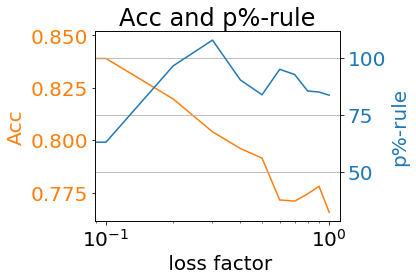

In [94]:
acc_a_cons_arr=np.array(acc_a_cons_arr, dtype=np.float)
p_a_cons_arr=np.array(p_a_cons_arr, dtype=np.float)

# plot p-rule vs covariance threshold
fig, ax1 = plt.subplots()
color = 'tab:orange'
ax1.set_xlabel(' loss factor')
ax1.set_ylabel('Acc', color=color)
ax1.semilogx(gammarange, acc_a_cons_arr, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('p%-rule', color=color)  # we already handled the x-label with ax1
ax2.semilogx(gammarange, p_a_cons_arr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Acc and p%-rule')
plt.grid(True)
plt.savefig('adult_loss_acc_p_rule.png', dpi=600)
plt.show()



In [89]:
# do some tests
def compare_uncons_cons():
    """ Load the adult data """
    X, y, x_control = load_adult_data('./') # set the argument to none, or no arguments if you want to test with the whole data -- we are subsampling for performance speedup
    ut.compute_p_rule(x_control["sex"], y) # compute the p-rule in the original data

    """ Split the data into train and test """
    X = ut.add_intercept(X) # add intercept to X before applying the linear classifier
    train_fold_size = 0.7
    x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

    apply_fairness_constraints = None
    apply_accuracy_constraint = None
    sep_constraint = None

    loss_function = lf._logistic_loss
    sensitive_attrs = ["sex"]
    sensitive_attrs_to_cov_thresh = {}
    gamma = None

    def train_test_classifier():
        w = ut.train_model(x_train, y_train, x_control_train, loss_function, 
                           apply_fairness_constraints, apply_accuracy_constraint, 
                           sep_constraint, sensitive_attrs, 
                           sensitive_attrs_to_cov_thresh, gamma)
        y_pred = np.sign(np.dot(x_test, w))
        return w, y_pred


    """ Classify the data while optimizing for accuracy """
    print
    print("== Unconstrained (original) classifier ==")
    # all constraint flags are set to 0 since we want to train an unconstrained (original) classifier
    apply_fairness_constraints = 0
    apply_accuracy_constraint = 0
    sep_constraint = 0
    w_uncons, y_pred_uncons = train_test_classifier()

    """ Now classify such that we optimize for accuracy while achieving perfect fairness """
    apply_fairness_constraints = 1 # set this flag to one since we want to optimize accuracy subject to fairness constraints
    apply_accuracy_constraint = 0
    sep_constraint = 0
    c = 0.1
    sensitive_attrs_to_cov_thresh = {"sex":c}
    print("== Classifier with fairness constraint == c=%f"%c)
    w_f_cons, y_pred_f_cons  = train_test_classifier()
        
    """ Classify such that we optimize for fairness subject to a certain loss in accuracy """
    apply_fairness_constraints = 0 # set this flag to one since we want to optimize accuracy subject to fairness constraints
    apply_accuracy_constraint = 1
    sep_constraint = 0
    gamma = 0.5
    print("== Classifier with accuracy constraint ==, gamma=%f"%gamma)
    w_a_cons, y_pred_a_cons = train_test_classifier()
    
    return y_test, y_pred_uncons, y_pred_f_cons, y_pred_a_cons

